# Erdös Institute
## Data Science Boot Camp Project: Police Interaction
--- 
[ICPSR 38872 dataset](https://www.icpsr.umich.edu/web/NACJD/studies/38872), focusing on the following features:
- **AGE** (Categorical)
- **HISP** (Hispanic status)
- **SEX**
- **INCOME**
- **V347** (Target: Indicator of proper police behavior)

In [1]:
# Importing libraries needed
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (confusion_matrix, classification_report, 
                           ConfusionMatrixDisplay, roc_curve, auc, confusion_matrix, roc_auc_score, PrecisionRecallDisplay)

# install imbalanced learn in your conda environment before preceding
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.calibration import CalibratedClassifierCV, calibration_curve, CalibrationDisplay
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier


df = pd.read_csv('/Users/patrickma1994/Documents/data.tsv', sep='\t',dtype='str')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130122 entries, 0 to 130121
Columns: 277 entries, SCRMCTRL to V353
dtypes: object(277)
memory usage: 275.0+ MB


In [2]:
# Checking if the value satisfy the codebook
print(df['V347'].value_counts())

V347
9     112008
1      16628
2        903
3        529
8         40
98        14
Name: count, dtype: int64


By checking the codebook and extracting the features wanted, we define a `df_m` matrix that only contains the selected data for simpler calculation.

In [3]:
df_m = df[['AGE', 'HISP', 'SEX', 'INCOME', 'V347']].rename(columns={'V347': 'proper_behave'})
df_m.head()

,AGE,HISP,SEX,INCOME,proper_behave
0,3,3,2,3,9
1,3,3,1,3,9
2,3,1,2,4,9
3,3,1,1,4,9
4,4,1,2,3,9


In [4]:
# Convert columns to categorical
df_m['AGE'] = pd.Categorical(df_m['AGE'])
df_m['HISP'] = pd.Categorical(df_m['HISP'])
df_m['SEX'] = pd.Categorical(df_m['SEX'])
df_m['INCOME'] = pd.Categorical(df_m['INCOME'])

# Filter rows where proper_behave is 1 or 2
df_m = df_m[df_m['proper_behave'].isin(['1', '2'])]

# Remap proper_behave values
df_m['proper_behave'] = df_m['proper_behave'].map({'1': 1, '2': 0})

# Convert proper_behave to numeric and checking the column number
df_m['proper_behave'] = pd.to_numeric(df_m['proper_behave'])
df_m.shape 
#df_m.head()
# Check missing values in all columns
print("Missing values in each column:")
print(df_m.isnull().sum())
# Seems to be no missing values to the current dataset

Missing values in each column:
AGE              0
HISP             0
SEX              0
INCOME           0
proper_behave    0
dtype: int64


The following codes drops missing values, but our data doesn't have missing values for the features selected. 

In [3]:
# Drop rows with missing values in AGE, HISP, SEX, and INCOME
df_m = df_m.dropna(subset=['AGE', 'HISP', 'SEX', 'INCOME'])

# Verify the shape after dropping missing values
print("\nDataFrame shape after dropping missing values:")
print(df_m.shape)

# Verify there are no more missing values in these columns
print("\nRemaining missing values:")
print(df_m[['AGE', 'HISP', 'SEX', 'INCOME']].isnull().sum())

X = pd.get_dummies(df_m[['AGE', 'HISP', 'SEX', 'INCOME']], drop_first=True)
y = df_m['proper_behave']



DataFrame shape after dropping missing values:
(130122, 5)

Remaining missing values:
AGE       0
HISP      0
SEX       0
INCOME    0
dtype: int64


### Learning the data
---
To better learn the data, we want to check some explanatory variables to check the distribution of the data.

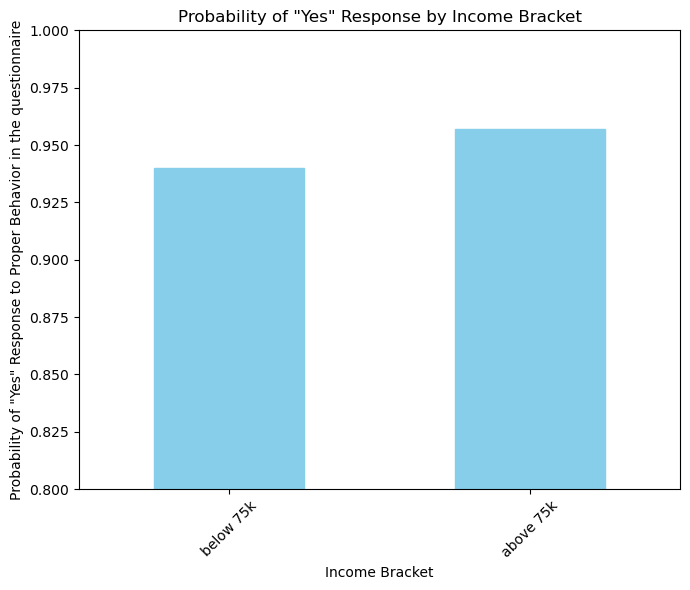

In [10]:
# Map income codes to labels
income_map = {'3': "below 75k", '4': "above 75k"}
df_m['INCOME_LABEL'] = df_m['INCOME'].map(income_map)

# Calculate mean probability of "Yes" (proper_behave=1) for each income label
income_probs = df_m.groupby('INCOME_LABEL', observed=False)['proper_behave'].mean()

# Plot the mean probability for each income label
plt.figure(figsize=(7, 6))
income_probs.plot(kind='bar', color='skyblue', edgecolor='skyblue')
plt.ylabel('Probability of "Yes" Response to Proper Behavior in the questionnaire')
plt.xlabel('Income Bracket')
plt.title('Probability of "Yes" Response by Income Bracket')
plt.ylim(0.8, 1.0)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("outputs/income_bracket_probability.png", dpi=300)
plt.show()

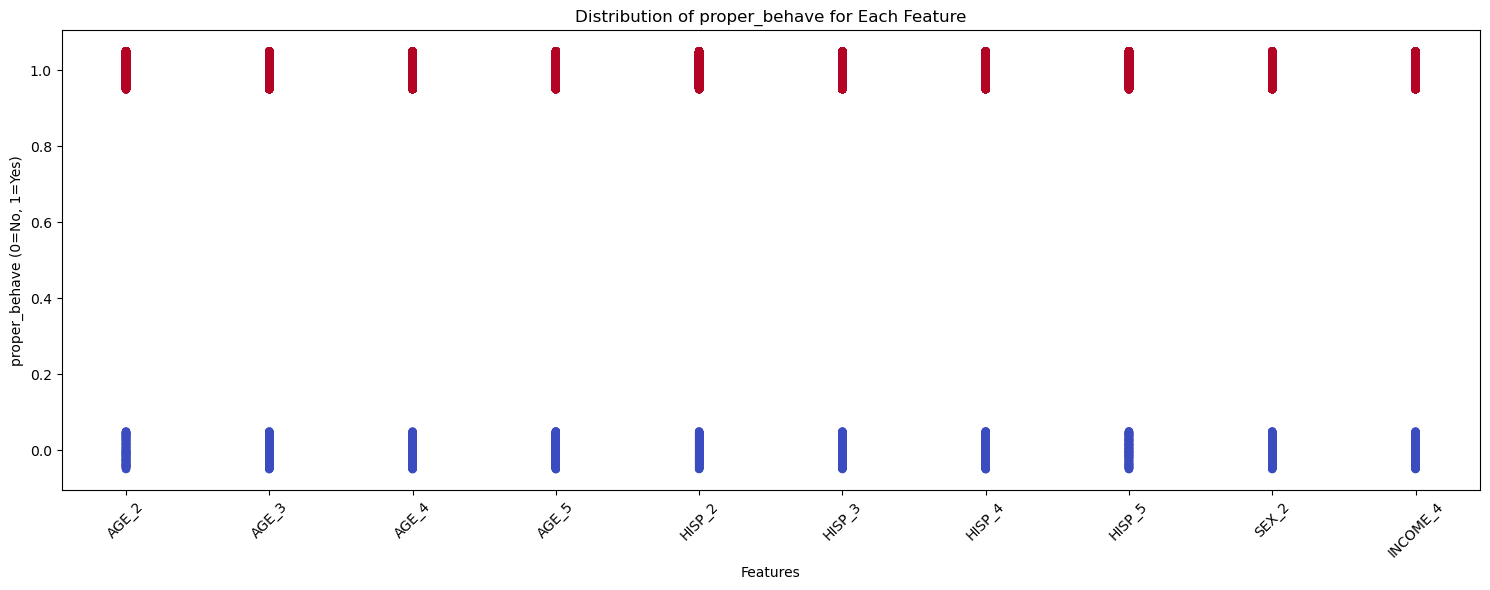

In [11]:
# Plot all features on the x-axis, y-axis as 0 and 1 (proper_behave)
plt.figure(figsize=(15, 6))
for i, col in enumerate(X.columns):
    # Use jitter for y to avoid overlap
    y_jitter = y + np.random.uniform(-0.05, 0.05, size=len(y))
    plt.scatter([col]*len(y), y_jitter, alpha=0.2, label=col if i == 0 else "", c=y, cmap='coolwarm', edgecolor='none')

plt.ylabel('proper_behave (0=No, 1=Yes)')
plt.xlabel('Features')
plt.title('Distribution of proper_behave for Each Feature')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

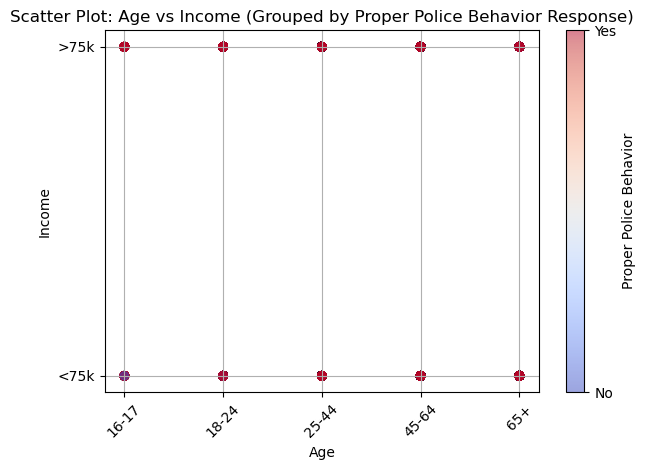

In [13]:
# Scatter plot of age vs income, colored by response to proper_behave
age_map = {'1': '16-17', '2': '18-24', '3': '25-44', '4': '45-64', '5': '65+'}
age_labels = df_m['AGE'].map(age_map)
age_codes = df_m['AGE'].astype(int)
income_codes = df_m['INCOME'].astype(int)

scatter = plt.scatter(
    age_codes,
    income_codes,
    c=df_m['proper_behave'],
    cmap='coolwarm',
    alpha=0.5,
    label=None
)
plt.xlabel('Age')
plt.ylabel('Income')
plt.title('Scatter Plot: Age vs Income (Grouped by Proper Police Behavior Response)')
plt.xticks(ticks=np.arange(1, 6), labels=list(age_map.values()), rotation=45)
plt.yticks(ticks=np.arange(3, 5), labels=list(income_map.values()))

cbar = plt.colorbar(scatter, ticks=[0, 1])
cbar.ax.set_yticklabels(['No', 'Yes'])
cbar.set_label('Proper Police Behavior')
plt.grid(True)
plt.tight_layout()
plt.show()

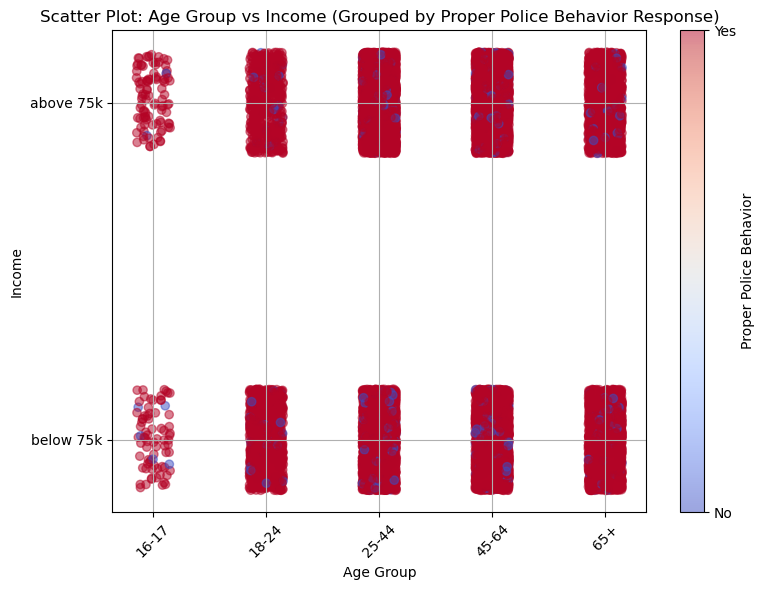

In [14]:
# Scatter plot of age vs income, colored by response to proper_behave, with jitter to separate overlapping points
age_map = {'1': '16-17', '2': '18-24', '3': '25-44', '4': '45-64', '5': '65+'}
income_map = {'3': "below 75k", '4': "above 75k"}

def jitter(values, amount=0.15):
    return values + np.random.uniform(-amount, amount, size=len(values))

age_codes = df_m['AGE'].astype(int)
income_codes = df_m['INCOME'].astype(int)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    jitter(age_codes),
    jitter(income_codes),
    c=df_m['proper_behave'],
    cmap='coolwarm',
    alpha=0.5
)
plt.xlabel('Age Group')
plt.ylabel('Income')
plt.title('Scatter Plot: Age Group vs Income (Grouped by Proper Police Behavior Response)')
plt.xticks(ticks=np.arange(1, 6), labels=[age_map[str(i)] for i in range(1, 6)], rotation=45)
plt.yticks(ticks=[3, 4], labels=[income_map[str(i)] for i in [3, 4]])

cbar = plt.colorbar(scatter, ticks=[0, 1])
cbar.ax.set_yticklabels(['No', 'Yes'])
cbar.set_label('Proper Police Behavior')
plt.grid(True)
plt.tight_layout()
plt.show()

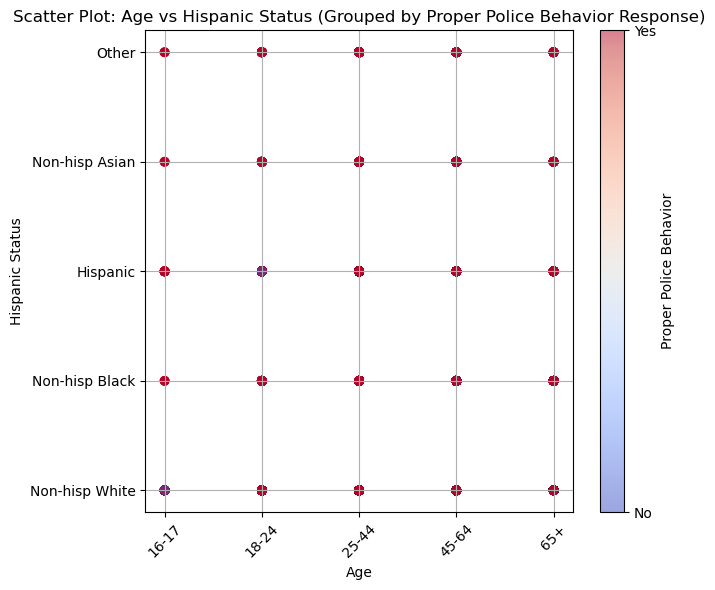

In [15]:
# Plot HISP vs AGE, grouped by proper_behave response
hisp_map = {'1': 'Non-hisp White', '2': 'Non-hisp Black', '3': 'Hispanic', '4': 'Non-hisp Asian', '5': 'Other'}
hisp_labels = df_m['HISP'].map(hisp_map)   
hisp_codes = df_m['HISP'].astype(int)

plt.figure(figsize=(7, 6))
scatter = plt.scatter(
    age_codes,
    hisp_codes,
    c=df_m['proper_behave'],
    cmap='coolwarm',
    alpha=0.5,
    label=None
)
plt.xlabel('Age')
plt.ylabel('Hispanic Status')
plt.title('Scatter Plot: Age vs Hispanic Status (Grouped by Proper Police Behavior Response)')
plt.xticks(ticks=np.arange(1, 6), labels=list(age_map.values()), rotation=45)
plt.yticks(ticks=np.arange(1, 6), labels=list(hisp_map.values()))

cbar = plt.colorbar(scatter, ticks=[0, 1])
cbar.ax.set_yticklabels(['No', 'Yes'])
cbar.set_label('Proper Police Behavior')
plt.grid(True)
plt.tight_layout()
plt.show()


In [12]:
# Map sex codes to labels
sex_map = {'1': 'Male', '2': 'Female'}
sex_labels = df_m['SEX'].map(sex_map)
sex_codes = df_m['SEX'].astype(int)

plt.figure(figsize=(7, 6))
scatter = plt.scatter(
    age_codes,
    sex_codes,
    c=df_m['proper_behave'],
    cmap='coolwarm',
    alpha=0.5
)
plt.xlabel('Age')
plt.ylabel('Gender')
plt.title('Scatter Plot: Age vs Gender (Grouped by Proper Police Behavior Response)')
plt.xticks(ticks=np.arange(1, 6), labels=list(age_map.values()), rotation=45)
plt.yticks(ticks=[1, 2], labels=['Male', 'Female'])

cbar = plt.colorbar(scatter, ticks=[0, 1])
cbar.ax.set_yticklabels(['No', 'Yes'])
cbar.set_label('Proper Police Behavior')
plt.grid(True)
plt.tight_layout()
plt.show()

NameError: name 'age_codes' is not defined

<Figure size 700x600 with 0 Axes>

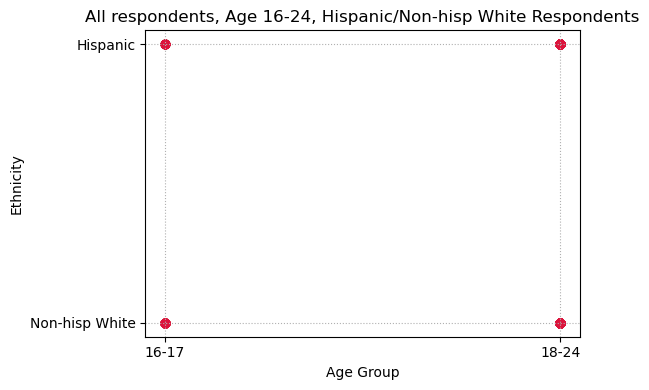

In [37]:
# Filter for: SEX = Female ('2'), AGE = 16-17 ('1') or 18-24 ('2'), HISP = 1 or 3, proper_behave = 0
filtered = df_m[
    (df_m['AGE'].isin(['1', '2'])) &
    (df_m['HISP'].isin(['1', '3'])) 
]

# Map codes to labels for plotting
no_age_map = {'1': '16-17', '2': '18-24'}
no_hisp_map = {'1': 'Non-hisp White', '3': 'Hispanic'}

plt.figure(figsize=(6, 4))
plt.scatter(
    filtered['AGE'].map(no_age_map),
    filtered['HISP'].map(no_hisp_map),
    alpha=0.7,
    color='crimson'
)
plt.xlabel('Age Group')
plt.ylabel('Ethnicity')
plt.title('All respondents, Age 16-24, Hispanic/Non-hisp White Respondents')
plt.grid(True, linestyle=':')
plt.tight_layout()
plt.show()

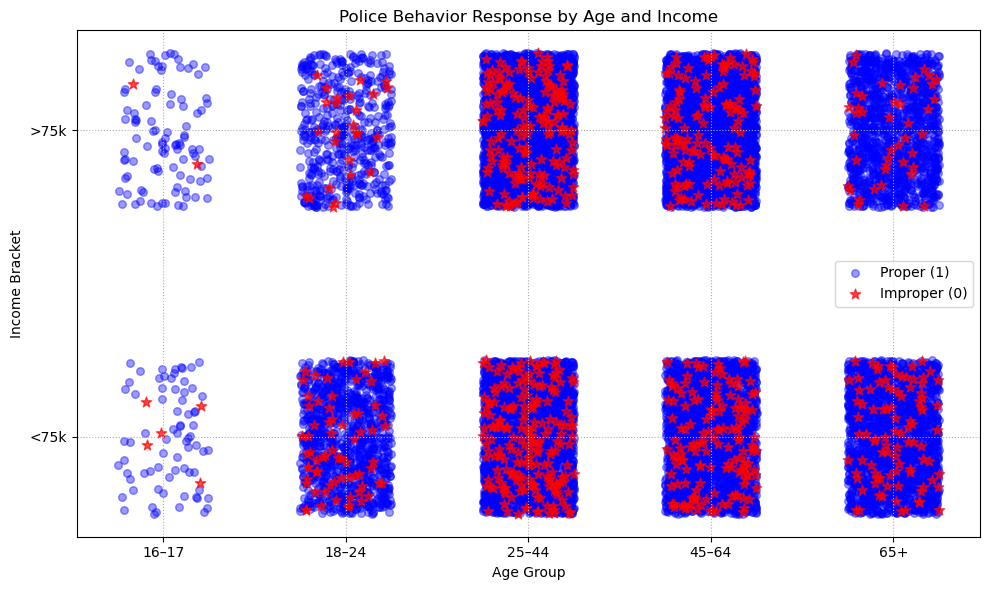

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Convert age and income to numeric
df_m['AGE_NUM'] = df_m['AGE'].astype(int)
df_m['INCOME_NUM'] = df_m['INCOME'].astype(int)

# Add jitter to separate overlapping points
def jitter(values, amount=0.25):
    return values + np.random.uniform(-amount, amount, size=len(values))

# Separate by behavior
df_yes = df_m[df_m['proper_behave'] == 1]
df_no  = df_m[df_m['proper_behave'] == 0]

# Plot
plt.figure(figsize=(10, 6))

plt.scatter(
    jitter(df_yes['AGE_NUM']),
    jitter(df_yes['INCOME_NUM']),
    color='blue',
    label='Proper (1)',
    alpha=0.4,
    s=30,
    marker='o'
)

plt.scatter(
    jitter(df_no['AGE_NUM']),
    jitter(df_no['INCOME_NUM']),
    color='red',
    label='Improper (0)',
    alpha=0.7,
    s=60,
    marker='*'
)

# Customize ticks and labels
plt.xticks([1, 2, 3, 4, 5], ['16–17', '18–24', '25–44', '45–64', '65+'])
plt.yticks([3, 4], ['<75k', '>75k'])
plt.xlabel('Age Group')
plt.ylabel('Income Bracket')
plt.title('Police Behavior Response by Age and Income')
plt.grid(True, linestyle=':')
plt.legend()
plt.tight_layout()
plt.savefig("outputs/police_behavior_age_income.png", dpi=300)
plt.show()

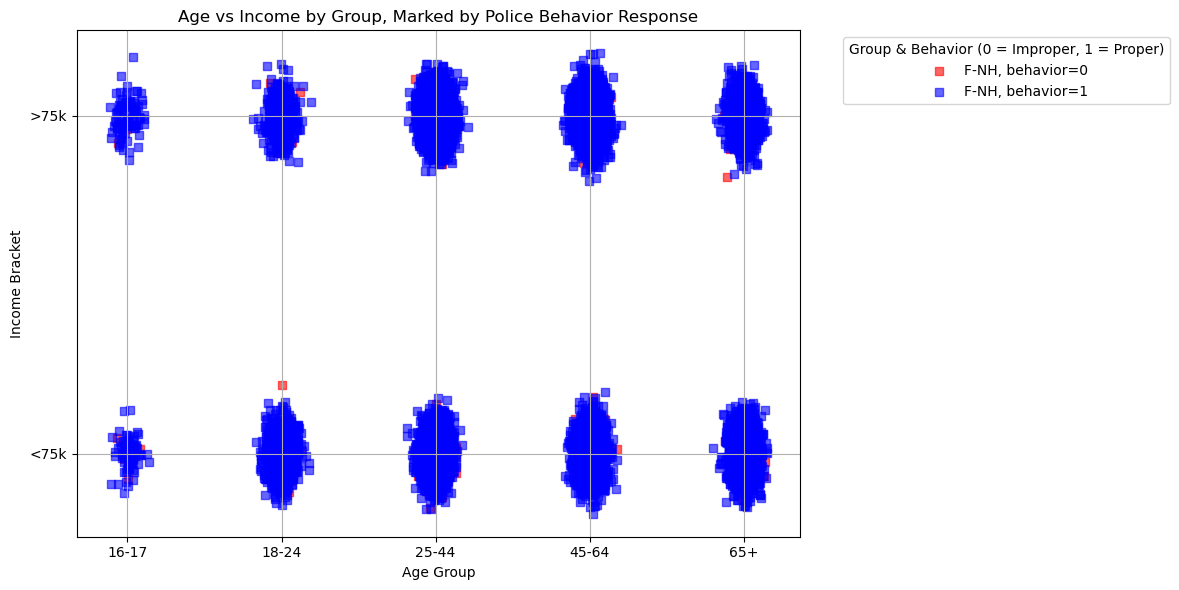

In [16]:
import pandas as pd
import matplotlib.pyplot as plt


'''np.random.seed(42)
size = 500
df_m = pd.DataFrame({
    'AGE': np.random.choice(['1', '2', '3', '4', '5'], size=size),
    'HISP': np.random.choice(['1', '3'], size=size),
    'SEX': np.random.choice(['1', '2'], size=size),
    'INCOME': np.random.choice(['3', '4'], size=size),
    'proper_behave': np.random.choice([0, 1], size=size)
})'''

# Add group label based on SEX and HISP
def group_label(row):
    sex = 'M' if row['SEX'] == '1' else 'F'
    eth = 'H' if row['HISP'] == '3' else 'NH'
    return f"{sex}-{eth}"

df_m['Group'] = df_m.apply(group_label, axis=1)

# Mapping for plotting
age_map = {'1': '16-17', '2': '18-24', '3': '25-44', '4': '45-64', '5': '65+'}
income_map = {'3': '<75k', '4': '>75k'}

df_m['AgeLabel'] = df_m['AGE'].map(age_map)
df_m['IncomeLabel'] = df_m['INCOME'].map(income_map)

# Encode axes
df_m['age_code'] = df_m['AGE'].astype(int)
df_m['income_code'] = df_m['INCOME'].astype(int)

# Plotting by group with different markers
markers = {'M-H': 'o', 'M-NH': '^', 'F-H': '*', 'F-NH': 's'}
colors = {0: 'red', 1: 'blue'}

fig, ax = plt.subplots(figsize=(12, 6))

for group in df_m['Group'].unique():
    for behavior in [0, 1]:
        subset = df_m[(df_m['Group'] == group) & (df_m['proper_behave'] == behavior)]
        ax.scatter(
            subset['age_code'] + 0.05 * np.random.randn(len(subset)),
            subset['income_code'] + 0.05 * np.random.randn(len(subset)),
            c=colors[behavior],
            marker=markers[group],
            label=f'{group}, behavior={behavior}',
            alpha=0.6
        )

# Axis labels and ticks
ax.set_xticks(range(1, 6))
ax.set_xticklabels([age_map[str(i)] for i in range(1, 6)])
ax.set_yticks([3, 4])
ax.set_yticklabels(['<75k', '>75k'])
ax.set_xlabel('Age Group')
ax.set_ylabel('Income Bracket')
ax.set_title('Age vs Income by Group, Marked by Police Behavior Response')
ax.legend(title='Group & Behavior (0 = Improper, 1 = Proper)', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True)

plt.tight_layout()
plt.savefig("outputs/police_behavior_grouped.png", dpi=300)
plt.show()


# Creating Grouping data

In [8]:
age_map = {'1': '16-17', '2': '18-24', '3': '25-44', '4': '45-64', '5': '65+'}
age_labels = df_m['AGE'].map(age_map)
hisp_map = {
    '1': 'NHW',  # Non-Hispanic White
    '2': 'NHB',  # Non-Hispanic Black
    '3': 'H',    # Hispanic
    '4': 'NHA',  # Non-Hispanic Asian
    '5': 'O'     # Other
}
hisp_labels = df_m['HISP'].map(hisp_map)
sex_map = {'1': 'M', '2': 'F'}
sex_labels = df_m['SEX'].map(sex_map)
income_map = {'3': '<75k', '4': '>75k'}
income_labels = df_m['INCOME'].map(income_map)
# Add labels for the group
df_m['age_label'] = age_labels
df_m['hisp_label'] = hisp_labels
df_m['sex_label'] = sex_labels
df_m['income_label'] = income_labels
df_m['age_code'] = df_m['AGE'].astype(int)
df_m['hisp_code'] = df_m['HISP'].astype(int)
df_m['income_code'] = df_m['INCOME'].astype(int)
df_m['sex_code'] = df_m['SEX'].astype(int)
# Combine labels into a single 'Group' column
df_m['Group'] = df_m['sex_label'].astype(str) + '-' + df_m['hisp_label'].astype(str)


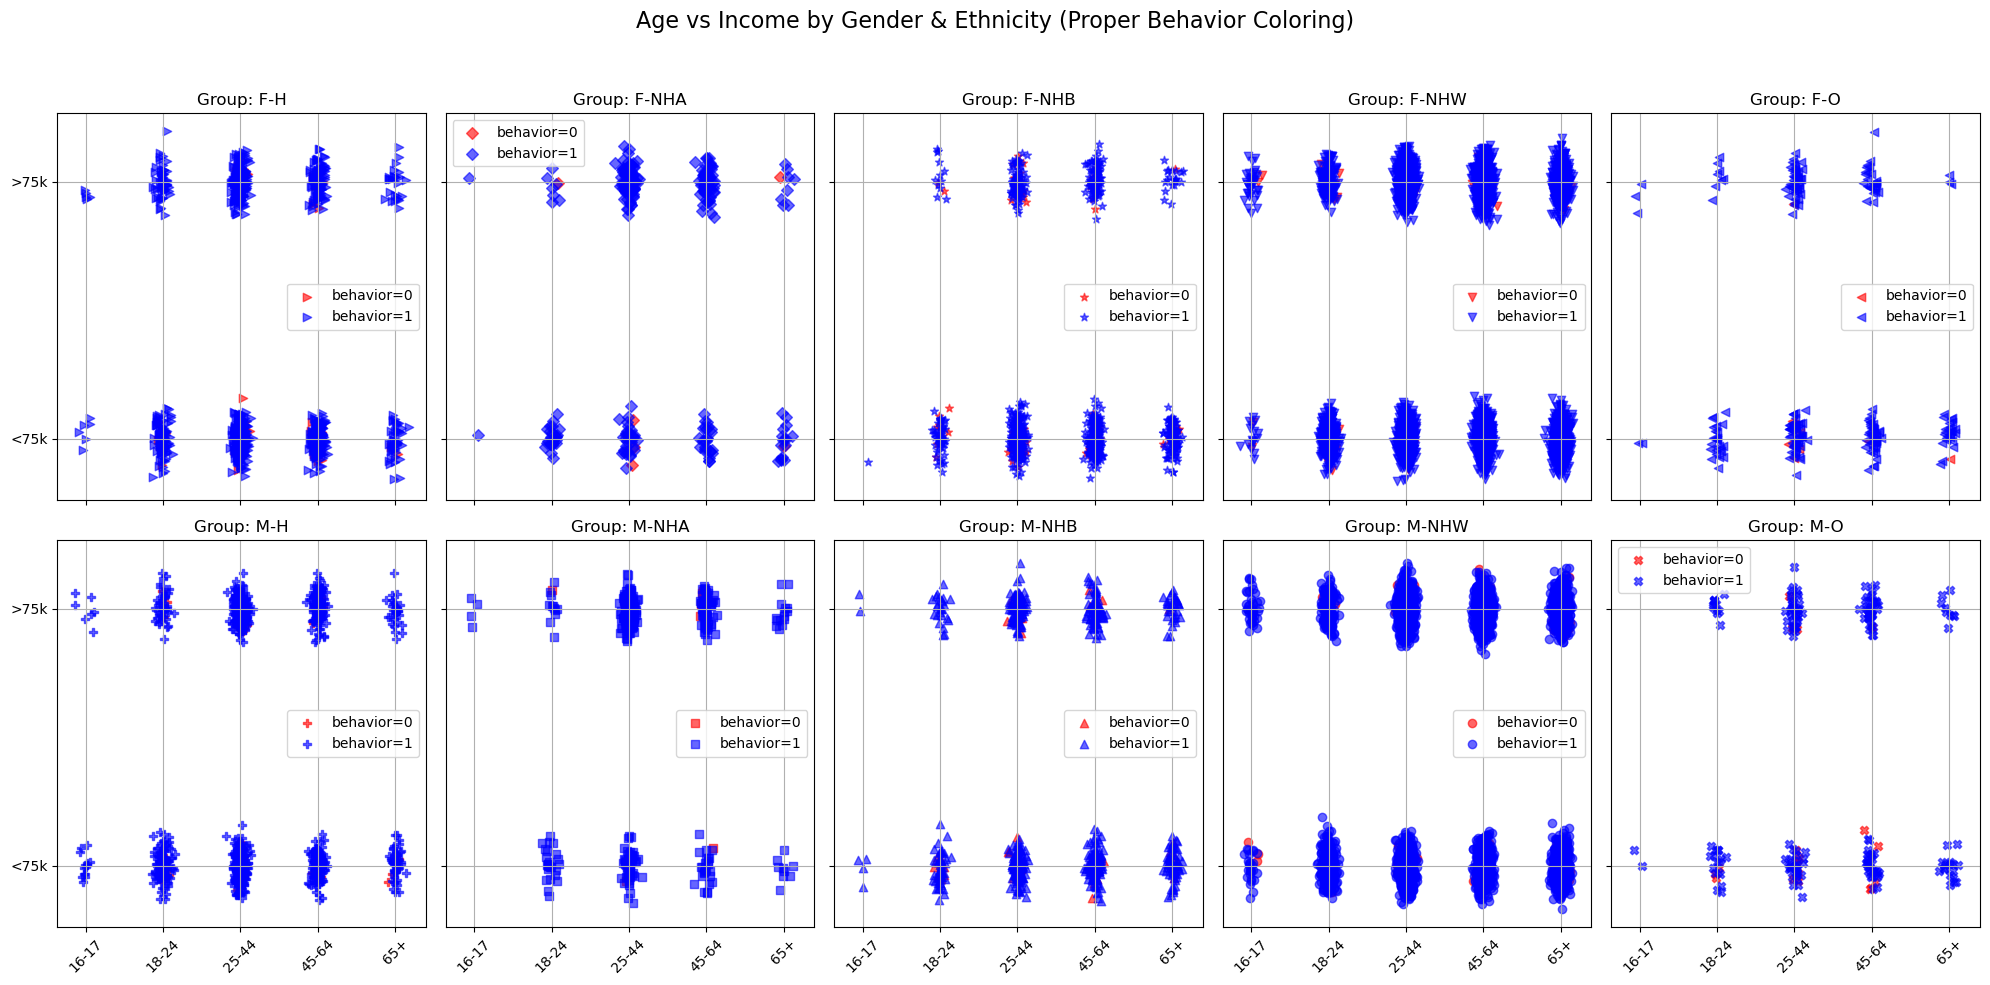

<Figure size 640x480 with 0 Axes>

In [11]:

# Plotting setup
age_codes = df_m['age_label'].astype('category').cat.codes
colors = {0: 'red', 1: 'blue'}
markers = {'M-NHW': 'o', 'M-NHB': '^', 'M-NHA': 's', 'M-H': 'P', 'M-O': 'X',
           'F-NHW': 'v', 'F-NHB': '*', 'F-NHA': 'D', 'F-H': '>', 'F-O': '<'}

unique_groups = sorted(df_m['Group'].unique())
fig, axs = plt.subplots(2, 5, figsize=(20, 10), sharex=True, sharey=True)
axs = axs.flatten()

for i, group in enumerate(unique_groups):
    ax = axs[i]
    for behavior in [0, 1]:
        subset = df_m[(df_m['Group'] == group) & (df_m['proper_behave'] == behavior)]
        ax.scatter(
            subset['age_code'] + 0.05 * np.random.randn(len(subset)),
            subset['income_code'] + 0.05 * np.random.randn(len(subset)),
            c=colors[behavior],
            marker=markers.get(group, 'o'),
            label=f'behavior={behavior}',
            alpha=0.6
        )
    ax.set_title(f'Group: {group}')
    ax.set_xticks(range(1, 6))
    ax.set_xticklabels([age_map[str(i)] for i in range(1, 6)], rotation=45)
    ax.set_yticks([3, 4])
    ax.set_yticklabels(['<75k', '>75k'])
    ax.grid(True)
    ax.legend()

fig.suptitle('Age vs Income by Gender & Ethnicity (Proper Behavior Coloring)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
plt.savefig("outputs/group_behavior_10plots.png", dpi=300)

### Creating filtered data with only AGE 16-24

In [50]:
df_filtered = df_m[
    (df_m['AGE'].isin(['1', '2']))& (df_m['HISP'].isin(['1', '3']))]
df_filtered.head()

,AGE,HISP,SEX,INCOME,proper_behave,INCOME_LABEL
22,1,1,2,4,1,above 75k
71,2,1,2,4,0,above 75k
96,2,1,2,4,1,above 75k
181,2,1,1,3,1,below 75k
291,2,1,1,4,1,above 75k


In [18]:
X = pd.get_dummies(df_filtered[['AGE', 'HISP', 'SEX', 'INCOME']], drop_first=True)
y = df_filtered['proper_behave']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

NameError: name 'df_filtered' is not defined

In [53]:
# Count how many proper_behave == 1 in y_train (corresponding to X_train)
count_properbehave_1 = (y_train == 1).sum()
print(f"Number of proper_behave == 1 in X_train/y_train: {count_properbehave_1}")

# If you meant to count in X_train itself, X_train only contains features, not the target.
# So, the count is only meaningful in y_train.

Number of proper_behave == 1 in X_train/y_train: 1167


Model accuracy: 0.9472402597402597


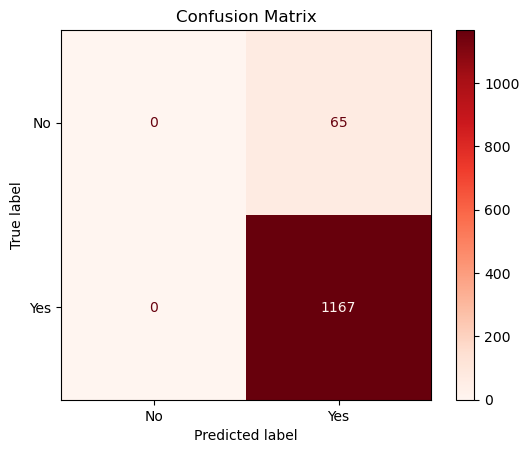


Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        65
           1       0.95      1.00      0.97      1167

    accuracy                           0.95      1232
   macro avg       0.47      0.50      0.49      1232
weighted avg       0.90      0.95      0.92      1232



/opt/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

In [54]:
model_lr = LogisticRegression(random_state=42)
model_lr.fit(X_train, y_train,)

print("Model accuracy:", model_lr.score(X_train, y_train))

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
# Get predictions on training data set
y_train_pred = model_lr.predict(X_train)
lr_proba_train = model_lr.predict_proba(X_train)[:, 1]

# Create and plot confusion matrix
cm = confusion_matrix(y_train, y_train_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No', 'Yes'])
disp.plot(cmap='Reds')
plt.title('Confusion Matrix')
plt.show()

# Print classification metrics
from sklearn.metrics import classification_report
print("\nClassification Report:")
print(classification_report(y_train, y_train_pred))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score
import ipywidgets as widgets
from IPython.display import display

# Use lr_proba_train (from your logistic regression training predictions)
probs = lr_proba_train  # Probabilities for the positive class
true_labels = y_train   # True labels for the training set

def plot_confusion_and_hist(threshold):
    y_pred = (probs >= threshold).astype(int)
    cm = confusion_matrix(true_labels, y_pred)
    acc = accuracy_score(true_labels, y_pred)
    f1 = f1_score(true_labels, y_pred)
    
    fig, axs = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={'width_ratios': [1, 1.2]})
    
    # Confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No', 'Yes'])
    disp.plot(cmap='Reds', values_format='d', ax=axs[0], colorbar=False)
    axs[0].set_title(f'Logistic Regression\n(Threshold={threshold:.2f})')
    
    # Histogram of predicted probabilities
    axs[1].hist(probs, bins=30, color="#1A5A8F", edgecolor='white', alpha=0.85)
    axs[1].axvline(threshold, color='crimson', linestyle='--', linewidth=2, label=f'Threshold = {threshold:.2f}')
    axs[1].set_title('Distribution of Predicted Probabilities')
    axs[1].set_xlabel('Predicted Probability')
    axs[1].set_ylabel('Count')
    axs[1].legend()
    axs[1].grid(axis='y', linestyle=':', alpha=0.7)
    
    plt.tight_layout()
    plt.show()
    
    print(f'Accuracy: {acc:.3f}')
    print(f'F1 Score: {f1:.3f}')


slider = widgets.FloatSlider(value=0.5, min=0.0, max=1.0, step=0.01, description='Threshold:')
widgets.interact(plot_confusion_and_hist, threshold=slider)

interactive(children=(FloatSlider(value=0.5, description='Threshold:', max=1.0, step=0.01), Output()), _dom_cl…

<function __main__.plot_confusion_and_hist(threshold)>

### Creating Training and Testing Data Sets for all data
---
- 80% training / 20% test using `train_test_split(random_state=42)`
- All models trained and tested on the **same split**


In [12]:
# Create dummy variables for categorical predictors
X = pd.get_dummies(df_m[['AGE', 'HISP', 'SEX', 'INCOME']], drop_first=True)
y = df_m['proper_behave']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Logistic regression result
   - Baseline model  
   - Naturally well-calibrated under linear assumptions
---
In the following model setup, the y(dependent variable is "proper_behave"), the dependent variable is the following:
1. HISP: surveys if the the interviewee's ethnicity
2. INCOME: surveys the interviewee's income level
3. SEX: surveys the interviewee's gender
4. AGE: surveys the interviewee's age

A confusion matrix is provided below.

Model accuracy: 0.9491585852823731


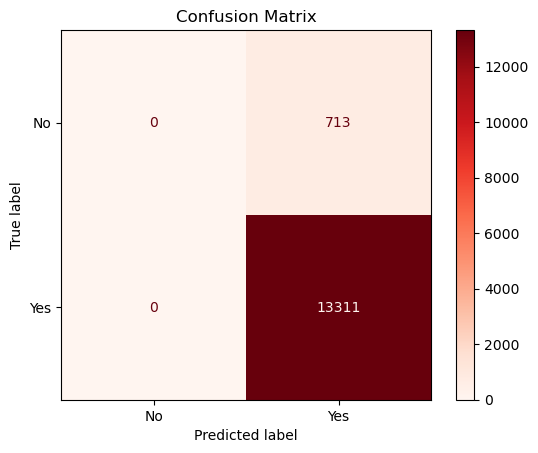


Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       713
           1       0.95      1.00      0.97     13311

    accuracy                           0.95     14024
   macro avg       0.47      0.50      0.49     14024
weighted avg       0.90      0.95      0.92     14024



/opt/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

In [62]:
# Create and fit the logistic regression model
model_lr = LogisticRegression(random_state=42)
model_lr.fit(X_train, y_train,)

print("Model accuracy:", model_lr.score(X_train, y_train))

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
# Get predictions on training data set
y_train_pred = model_lr.predict(X_train)
lr_proba_train = model_lr.predict_proba(X_train)[:, 1]

# Create and plot confusion matrix
cm = confusion_matrix(y_train, y_train_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No', 'Yes'])
disp.plot(cmap='Reds')
plt.title('Confusion Matrix')
plt.show()

# Print classification metrics
from sklearn.metrics import classification_report
print("\nClassification Report:")
print(classification_report(y_train, y_train_pred))

In [63]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score
import ipywidgets as widgets
from IPython.display import display

# Use lr_proba_train (from your logistic regression training predictions)
probs = lr_proba_train  # Probabilities for the positive class
true_labels = y_train   # True labels for the training set

def plot_confusion_and_hist(threshold):
    y_pred = (probs >= threshold).astype(int)
    cm = confusion_matrix(true_labels, y_pred)
    acc = accuracy_score(true_labels, y_pred)
    f1 = f1_score(true_labels, y_pred)
    
    fig, axs = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={'width_ratios': [1, 1.2]})
    
    # Confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No', 'Yes'])
    disp.plot(cmap='Reds', values_format='d', ax=axs[0], colorbar=False)
    axs[0].set_title(f'Logistic Regression\n(Threshold={threshold:.2f})')
    
    # Histogram of predicted probabilities
    axs[1].hist(probs, bins=30, color="#1A5A8F", edgecolor='white', alpha=0.85)
    axs[1].axvline(threshold, color='crimson', linestyle='--', linewidth=2, label=f'Threshold = {threshold:.2f}')
    axs[1].set_title('Distribution of Predicted Probabilities')
    axs[1].set_xlabel('Predicted Probability')
    axs[1].set_ylabel('Count')
    axs[1].legend()
    axs[1].grid(axis='y', linestyle=':', alpha=0.7)
    
    plt.tight_layout()
    plt.show()
    
    print(f'Accuracy: {acc:.3f}')
    print(f'F1 Score: {f1:.3f}')


slider = widgets.FloatSlider(value=0.5, min=0.0, max=1.0, step=0.01, description='Threshold:')
widgets.interact(plot_confusion_and_hist, threshold=slider)

interactive(children=(FloatSlider(value=0.5, description='Threshold:', max=1.0, step=0.01), Output()), _dom_cl…

<function __main__.plot_confusion_and_hist(threshold)>

#### Reporting the logistic regression without SMOTE balancing
---
The coefficients of the logistic regression is as:

In [10]:
# Get model coefficients
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model_lr.coef_[0]
})
print("\nModel coefficients:")
print(coef_df)


Model coefficients:
    Feature  Coefficient
0     AGE_2    -0.228835
1     AGE_3    -0.307666
2     AGE_4    -0.305055
3     AGE_5     0.064544
4    HISP_2    -0.760991
5    HISP_3    -0.345771
6    HISP_4     0.066357
7    HISP_5    -0.150707
8     SEX_2     0.025924
9  INCOME_4     0.309839


Logistic Regression: adding cross-validation for better result.

In [13]:
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
threshold = 0.8  # set your custom threshold here

# Get cross-validated predicted probabilities
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
lr_cv_probs = cross_val_predict(model_lr, X, y, cv=cv, method='predict_proba')[:, 1]

# Apply threshold
y_pred = (lr_cv_probs >= threshold).astype(int)

# Calculate metrics
print("Accuracy:", accuracy_score(y, y_pred))
print("Precision:", precision_score(y, y_pred))
print("Recall:", recall_score(y, y_pred))
print("F1:", f1_score(y, y_pred))

Accuracy: 0.948491244081912
Precision: 0.948491244081912
Recall: 1.0
F1: 0.9735647999063204


### Adding visualization as the threshold changes

In [ ]:
# Adding visualization as the threshold changes
probs = model_lr.predict_proba(X)[:, 1]
true_labels = y.values

def cv_metrics_vs_threshold(threshold):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    accs, precs, recs, f1s = [], [], [], []
    for train_idx, test_idx in skf.split(probs, true_labels):
        y_true = true_labels[test_idx]
        y_pred = (probs[test_idx] >= threshold).astype(int)
        accs.append(accuracy_score(y_true, y_pred))
        precs.append(precision_score(y_true, y_pred, zero_division=0))
        recs.append(recall_score(y_true, y_pred, zero_division=0))
        f1s.append(f1_score(y_true, y_pred, zero_division=0))
    metrics = [np.mean(accs), np.mean(precs), np.mean(recs), np.mean(f1s)]
    stds = [np.std(accs), np.std(precs), np.std(recs), np.std(f1s)]
    colors = ['#4682B4', '#6A5ACD', '#20B2AA', '#FF8C00']
    fig, ax = plt.subplots(figsize=(9, 5))  # Increased figure size
    bars = ax.bar(['Accuracy', 'Precision', 'Recall', 'F1'], metrics, yerr=[2*s for s in stds],
                  capsize=10, color=colors, edgecolor='black', alpha=0.85)
    ax.set_ylim(0, 1)
    ax.set_title(f"5-Fold CV Logstic Regression at Threshold={threshold:.2f}", fontsize=12, fontweight='bold', pad=20)
    ax.set_ylabel("Mean CV Score", fontsize=14)
    for bar, mean in zip(bars, metrics):
        ax.text(bar.get_x() + bar.get_width()/2, mean + 0.03, f"{mean:.2f}", ha='center', va='bottom', fontsize=12, fontweight='bold')
    ax.grid(axis='y', linestyle=':', alpha=0.7)
    ax.spines[['top', 'right']].set_visible(False)
    plt.tight_layout(rect=[0, 0, 1, 0.97])  # Leave more space for the title
    plt.show()
    print(f"Accuracy: {metrics[0]:.3f}, Precision: {metrics[1]:.3f}, Recall: {metrics[2]:.3f}, F1: {metrics[3]:.3f}")

widgets.interact(cv_metrics_vs_threshold, threshold=widgets.FloatSlider(value=0.5, min=0.0, max=1.0, step=0.01, description='Threshold'))

interactive(children=(FloatSlider(value=0.5, description='Threshold', max=1.0, step=0.01), Output()), _dom_cla…

<function __main__.cv_metrics_vs_threshold(threshold)>

### SMOTE for imbalanced data with logistic regression
---

In [66]:
#Ensure numeric types for SMOTE
X_train = X_train.astype(float)  # or int
y_train = y_train.astype(int)
# Implementing SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Train model with SMOTE-balanced data
model_lr_smote = LogisticRegression(max_iter=1000, random_state=42)
model_lr_smote.fit(X_resampled, y_resampled)

# Evaluate SMOTE model and get predictions on training data
# Note: In practice, you would evaluate on a separate test set, but here we use
y_pred_smote = model_lr_smote.predict(X_train)
lr_smote_proba = model_lr_smote.predict_proba(X_train)[:, 1]
# Create and plot confusion matrix for SMOTE model
print("\nClassification Report - SMOTE Model:")
print(classification_report(y_train, y_pred_smote))



Classification Report - SMOTE Model:
              precision    recall  f1-score   support

           0       0.07      0.56      0.12       713
           1       0.96      0.57      0.72     13311

    accuracy                           0.57     14024
   macro avg       0.51      0.57      0.42     14024
weighted avg       0.92      0.57      0.69     14024



### Printing out the confusion matrix for SMOTE and ROC curve
---

In [67]:
# create SMOTE LR model with changing threshold confusion matrix
def plot_smote_confusion_and_hist(threshold):
    y_pred = (lr_smote_proba >= threshold).astype(int)
    cm = confusion_matrix(y_train, y_pred)
    acc = accuracy_score(y_train, y_pred)
    f1 = f1_score(y_train, y_pred)

    fig, axs = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={'width_ratios': [1, 1.2]})

    # Confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No', 'Yes'])
    disp.plot(cmap='Reds', values_format='d', ax=axs[0], colorbar=False)
    axs[0].set_title(f'SMOTE Logistic Regression\n(Threshold={threshold:.2f})')

    # Histogram of predicted probabilities
    axs[1].hist(lr_smote_proba, bins=30, color="#1A5A8F", edgecolor='white', alpha=0.85)
    axs[1].axvline(threshold, color='crimson', linestyle='--', linewidth=2, label=f'Threshold = {threshold:.2f}')
    axs[1].set_title('Distribution of Predicted Probabilities')
    axs[1].set_xlabel('Predicted Probability')
    axs[1].set_ylabel('Count')
    axs[1].legend()
    axs[1].grid(axis='y', linestyle=':', alpha=0.7)

    plt.tight_layout()
    plt.show()

    print(f'Accuracy: {acc:.3f}')
    print(f'F1 Score: {f1:.3f}')

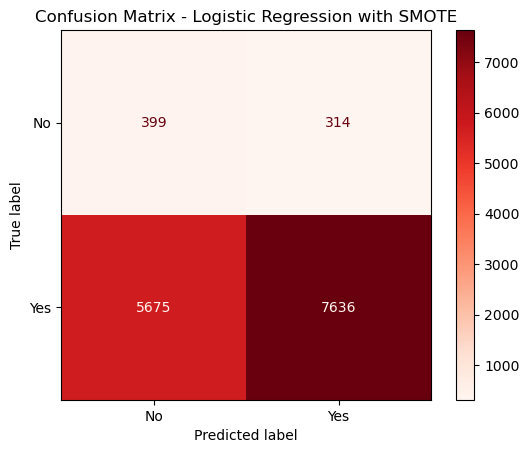

In [69]:
# Plot SMOTE confusion matrix
cm_smote = confusion_matrix(y_train, y_pred_smote)
disp_smote = ConfusionMatrixDisplay(confusion_matrix=cm_smote, display_labels=['No', 'Yes'])
disp_smote.plot(cmap='Reds')
plt.title('Confusion Matrix - Logistic Regression with SMOTE')
plt.show()



Classification Report:
              precision    recall  f1-score   support

           0       0.07      0.56      0.12       713
           1       0.96      0.57      0.72     13311

    accuracy                           0.57     14024
   macro avg       0.51      0.57      0.42     14024
weighted avg       0.92      0.57      0.69     14024



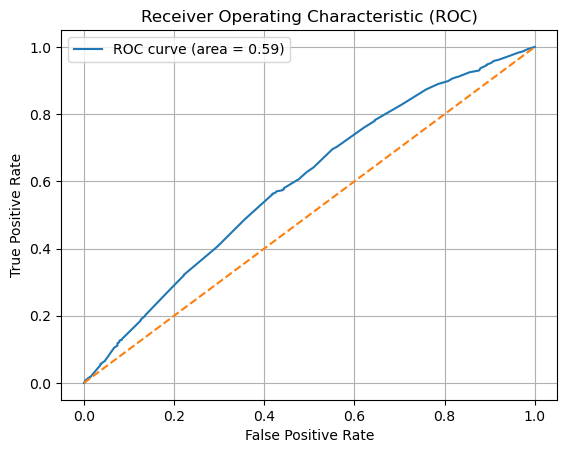


Classification Report with threshold = 0.9:
              precision    recall  f1-score   support

           0       0.05      1.00      0.10       713
           1       0.00      0.00      0.00     13311

    accuracy                           0.05     14024
   macro avg       0.03      0.50      0.05     14024
weighted avg       0.00      0.05      0.00     14024



/opt/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

In [70]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_train, y_pred_smote))

# ROC Curve
y_scores = model_lr_smote.predict_proba(X_train)[:, 1]
fpr, tpr, _ = roc_curve(y_train, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend()
plt.grid(True)
plt.show()

# 11. Try different thresholds
threshold = 0.90  # Custom threshold
y_pred_custom = (y_scores > threshold).astype(int)

print(f"\nClassification Report with threshold = {threshold}:")
print(classification_report(y_train, y_pred_custom))

### Fitting the XGB model
---
We'll now implement XGBoost, which often provides better performance for classification tasks. We'll combine it with SMOTE to handle class imbalance.

In [ ]:
# Apply SMOTE to balance training data
#smote = SMOTE(random_state=42)
#X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
# Should already have resampled X and y, if not can resample here
print("Resampled label distribution:", Counter(y_resampled))

In [71]:
# Initialize and train XGBoost model
xgb_model = XGBClassifier(
    eval_metric='logloss',
    scale_pos_weight=1.1,
    random_state=42
)
xgb_model.fit(X_resampled, y_resampled)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test)
y_scores_xgb = xgb_model.predict_proba(X_test)[:, 1]

### Model Evaluation - XGBoost Results
---
Let's evaluate the XGBoost model's performance using various metrics and visualizations.

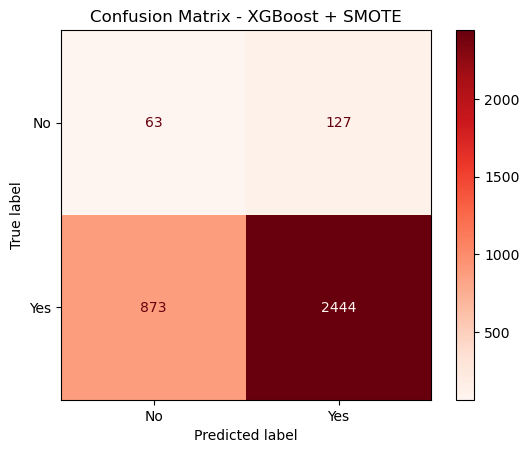


Classification Report:
              precision    recall  f1-score   support

           0       0.07      0.33      0.11       190
           1       0.95      0.74      0.83      3317

    accuracy                           0.71      3507
   macro avg       0.51      0.53      0.47      3507
weighted avg       0.90      0.71      0.79      3507



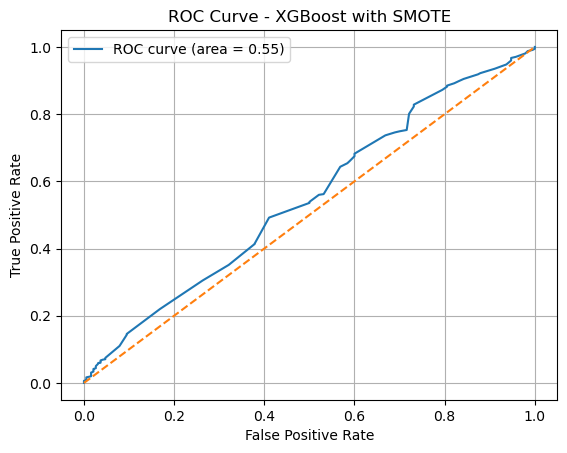

In [72]:
cm = confusion_matrix(y_test, y_pred_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No', 'Yes'])
disp.plot(cmap='Reds')
plt.title("Confusion Matrix - XGBoost + SMOTE")
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_scores_xgb)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost with SMOTE')
plt.legend()
plt.grid(True)
plt.show()

### XGBoost with Calibrated Classification
---

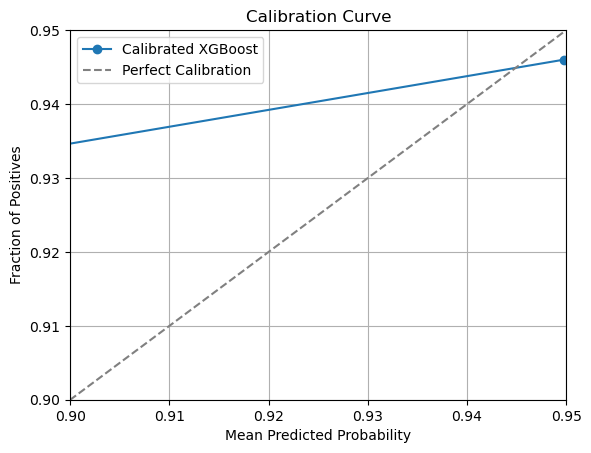

In [81]:
calibrated_xgb = CalibratedClassifierCV(estimator=xgb_model, method='sigmoid', cv=5)
calibrated_xgb.fit(X_train, y_train)

# Predict calibrated probabilities
calibrated_probs = calibrated_xgb.predict_proba(X_test)[:, 1]

prob_true_xgb, prob_pred_xgb = calibration_curve(y_test, calibrated_probs, n_bins=10)

plt.plot(prob_pred_xgb, prob_true_xgb, marker='o', label='Calibrated XGBoost')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')
plt.xlim(0.90, 0.95)
plt.ylim(0.90, 0.95)
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve')
plt.legend()
plt.grid()
plt.show()

### Adaboost Model
---


In [92]:
# Initialize and fit model
ada_model = AdaBoostClassifier(n_estimators=100, random_state=42)
ada_model.fit(X_train, y_train)

# Get predicted probabilities for ROC, PR curves, and calibration
ada_probs = ada_model.predict_proba(X_test)[:, 1]
ada_train_probs = ada_model.predict_proba(X_train)[:, 1]
# ROC Curve for AdaBoost
ada_roc_auc = roc_auc_score(y_test, ada_probs)
print(f"AdaBoost ROC AUC: {ada_roc_auc:.3f}")

AdaBoost ROC AUC: 0.544


Delivering the AdaBoost calibration curve

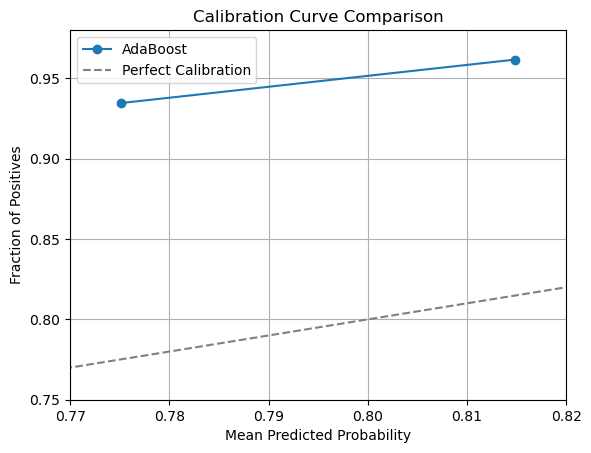

In [93]:
prob_true_ada, prob_pred_ada = calibration_curve(y_test, ada_probs, n_bins=10)
prob_true_ada_train, prob_pred_ada_train = calibration_curve(y_train, ada_train_probs, n_bins=10)
#plt.plot(prob_pred_xgb, prob_true_xgb, marker='o', label='Calibrated XGBoost')
plt.plot(prob_pred_ada_train, prob_true_ada_train, marker='o', label='AdaBoost')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')

plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.xlim(0.77, 0.82)
plt.ylim(0.75, 0.98)
plt.title('Calibration Curve Comparison')
plt.legend()
plt.grid()
plt.show()


### Comparing all models graphically
---

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

# Plot Logistic Regression with SMOTE
CalibrationDisplay.from_estimator(model_lr, X_test, y_test, name='Logistic Regression base model',
                                  n_bins=20, strategy='quantile', ax=ax)
CalibrationDisplay.from_estimator(model_lr_smote, X_test, y_test, name='Logistic Regression with SMOTE',
                                  n_bins=20, strategy='quantile', ax=ax)

# Plot AdaBoost
CalibrationDisplay.from_estimator(ada_model, X_test, y_test, name='AdaBoost',
                                  n_bins=20, strategy='quantile', ax=ax)

# Plot Calibrated XGBoost
CalibrationDisplay.from_estimator(calibrated_xgb, X_test, y_test, name='Calibrated XGBoost',
                                  n_bins=20, strategy='quantile', ax=ax)

# Add perfect calibration line
ax.plot([0, 1], [0, 1], linestyle='--', color='black', label='Perfectly calibrated')

# Final formatting
ax.set_title('Calibration Curve Comparison')
ax.set_xlabel('Mean predicted probability (Positive class: 1)')
ax.set_ylabel('Fraction of positives (Positive class: 1)')
ax.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Creating the probability histogram comparison
---

In [ ]:
# Set up plots
fig, axs = plt.subplots(1, 3, figsize=(18, 4), sharey=True)

# Plot histograms
axs[0].hist(lr_proba, bins=10, color='red', edgecolor='black')
axs[0].set_title("Logistic Regression")
axs[0].set_xlabel("Mean predicted probability")
axs[0].set_ylabel("Count")

axs[0].hist(lr_smote_proba, bins=10, color='blue', edgecolor='black')
axs[0].set_title("Logistic Regression")
axs[0].set_xlabel("Mean predicted probability")
axs[0].set_ylabel("Count")

axs[1].hist(ada_probs, bins=10, color='orange', edgecolor='black')
axs[1].set_title("AdaBoost")
axs[1].set_xlabel("Mean predicted probability")

axs[2].hist(calibrated_probs, bins=10, color='green', edgecolor='black')
axs[2].set_title("Calibrated XGBoost")
axs[2].set_xlabel("Mean predicted probability")

plt.suptitle("Predicted Probability Histograms (Confidence)")
plt.tight_layout()
plt.show()

In [ ]:
# Plot histograms of predicted probabilities for all models
# Ensure all models have been trained and probabilities calculated
plt.figure(figsize=(10, 6))
bins = np.linspace(0.5, 1.0, 30)  # Match earlier setup

plt.hist(lr_proba, bins=bins, alpha=0.5, label='Logistic Baseline', color='steelblue')
plt.hist(lr_smote_proba, bins=bins, alpha=0.5, label='Logistic with SMOTE', color='red')
plt.hist(ada_probs, bins=bins, alpha=0.5, label='AdaBoost', color='orange')
plt.hist(calibrated_probs, bins=bins, alpha=0.5, label='Calibrated XGBoost', color='green')

plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.title("Histogram of Predicted Probabilities")
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig("outputs/histogram_probs.png", dpi=300)
plt.show()

### Creating a ROC curve altogether
---

In [ ]:
# Roc Curve:
import os
os.makedirs("outputs", exist_ok=True)

from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

# Create new figure each time
fig, ax = plt.subplots(figsize=(8, 6))
RocCurveDisplay.from_predictions(y_test, lr_proba, name="Logistic baseline", ax=ax)
RocCurveDisplay.from_predictions(y_test, lr_smote_proba, name="Logistic with SMOTE", ax=ax)
RocCurveDisplay.from_predictions(y_test, ada_probs, name="AdaBoost", ax=ax)
RocCurveDisplay.from_predictions(y_test, calibrated_probs, name="Calibrated XGBoost", ax=ax)

plt.title("ROC Curve")
plt.grid()

# Save to file first
fig.savefig("outputs/roc_curve.png", dpi=300, bbox_inches='tight')

# Then show it
plt.show()
plt.close(fig)


### Creating precision recall curve
---

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
PrecisionRecallDisplay.from_predictions(y_test, lr_proba, name="Logistic", ax=ax)
PrecisionRecallDisplay.from_predictions(y_test, lr_smote_proba, name="Logistic", ax=ax)
PrecisionRecallDisplay.from_predictions(y_test, ada_probs, name="AdaBoost", ax=ax)
PrecisionRecallDisplay.from_predictions(y_test, calibrated_probs, name="Calibrated XGBoost", ax=ax)

plt.title("Precision-Recall Curve")
plt.grid()

# Save the figure BEFORE showing it
fig.savefig("outputs/precision_recall_curve.png", dpi=300, bbox_inches='tight')

# Show the figure
plt.show()
plt.close(fig)

### Regression by age groups
---

In [ ]:
age_map = {'1': '16-17', '2': '18-24', '3': '25-44', '4': '45-64', '5': '65+'}
age_labels = df_m['AGE'].map(age_map)
hisp_map = {
    '1': 'NHW',  # Non-Hispanic White
    '2': 'NHB',  # Non-Hispanic Black
    '3': 'H',    # Hispanic
    '4': 'NHA',  # Non-Hispanic Asian
    '5': 'O'     # Other
}
hisp_labels = df_m['HISP'].map(hisp_map)
sex_map = {'1': 'M', '2': 'F'}
sex_labels = df_m['SEX'].map(sex_map)
income_map = {'3': '<75k', '4': '>75k'}
income_labels = df_m['INCOME'].map(income_map)
# Add labels for the group
df_m['age_label'] = age_labels
df_m['hisp_label'] = hisp_labels
df_m['sex_label'] = sex_labels
df_m['income_label'] = income_labels
df_m['age_code'] = df_m['AGE'].astype(int)
df_m['hisp_code'] = df_m['HISP'].astype(int)
df_m['income_code'] = df_m['INCOME'].astype(int)
df_m['sex_code'] = df_m['SEX'].astype(int)
# Combine labels into a single 'Group' column
df_m['Group'] = df_m['sex_label'].astype(str) + '-' + df_m['hisp_label'].astype(str)

In [ ]:
# Defining X and y for the model and getting the training and test sets
X = pd.get_dummies(df_m[['AGE', 'HISP', 'SEX', 'INCOME']], drop_first=True)
y = df_m['proper_behave']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  

### By group fitting the model and reporting the scores. 
---
The group here defined is by AGE and by INCOME. This two seems to be the most important ones from previous data analysis.

   Group  Accuracy  Precision  Recall        F1
6    F-H  0.902597   0.902597     1.0  0.948805
3  F-NHA  0.952381   0.952381     1.0  0.975610
2  F-NHB  0.936975   0.936975     1.0  0.967462
0  F-NHW  0.953603   0.953603     1.0  0.976251
8    F-O  0.948052   0.948052     1.0  0.973333
5    M-H  0.929054   0.929054     1.0  0.963222
9  M-NHA  0.925926   0.925926     1.0  0.961538
4  M-NHB  0.906250   0.906250     1.0  0.950820
1  M-NHW  0.948211   0.948211     1.0  0.973417
7    M-O  0.935484   0.935484     1.0  0.966667


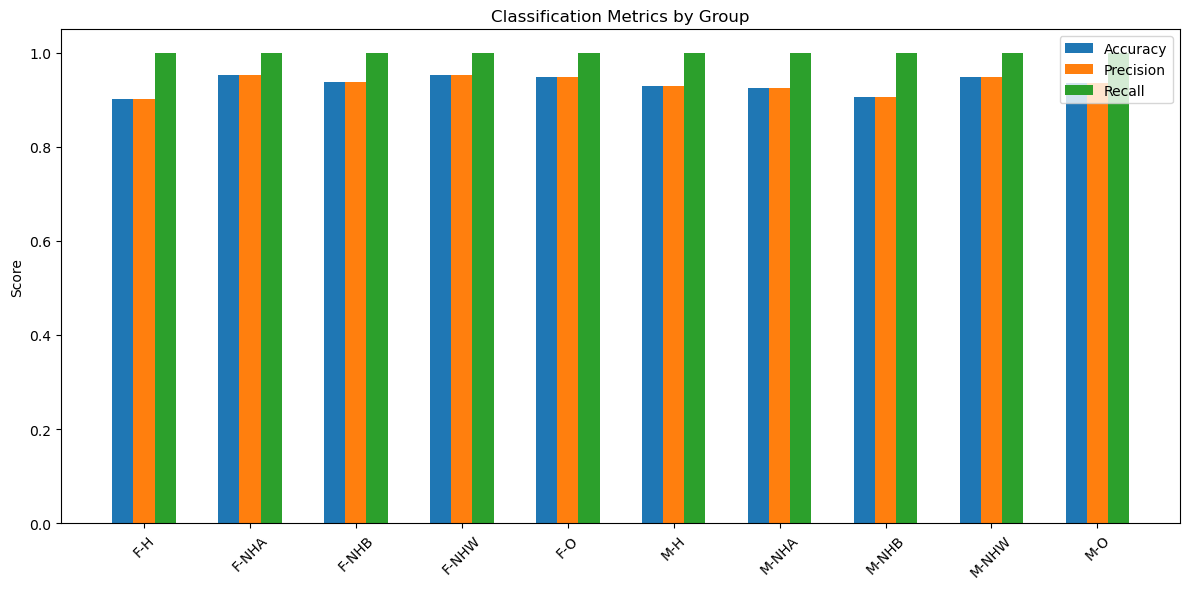

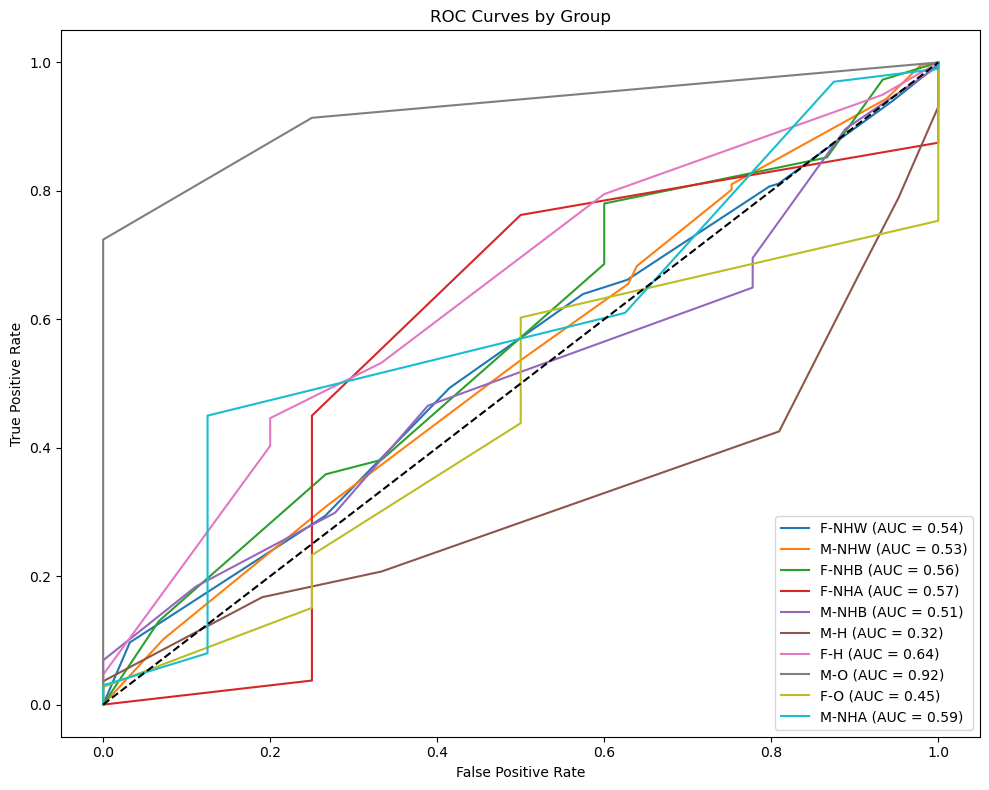

In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

# Encode features
X_cols = ['AGE', 'INCOME']
y_col = 'proper_behave'

# Storage for metrics and probabilities
metrics = []
roc_data = {}
prob_data = {}

# Train/test split per group
groups = df_m['Group'].unique()
for group in groups:
    df_group = df_m[df_m['Group'] == group]
    if df_group[y_col].nunique() < 2 or len(df_group) < 10:
        continue
    # Convert categorical columns to numeric codes
    X = df_group[X_cols].apply(lambda col: col.cat.codes if hasattr(col, "cat") else col)
    y = df_group[y_col]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    # Store probabilities
    prob_data[group] = y_prob

    # Store ROC
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    roc_data[group] = (fpr, tpr, roc_auc)

    # Metrics
    metrics.append({
        'Group': group,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, zero_division=0),
        'Recall': recall_score(y_test, y_pred, zero_division=0),
        'F1': f1_score(y_test, y_pred, zero_division=0)
    })

# Convert to DataFrame
metrics_df = pd.DataFrame(metrics)
metrics_df_sorted = metrics_df.sort_values(by='Group')

# Plot a bar chart of metrics
fig1, ax1 = plt.subplots(figsize=(12, 6))
bar_width = 0.2
x = np.arange(len(metrics_df_sorted['Group']))
ax1.bar(x - bar_width, metrics_df_sorted['Accuracy'], width=bar_width, label='Accuracy')
ax1.bar(x, metrics_df_sorted['Precision'], width=bar_width, label='Precision')
ax1.bar(x + bar_width, metrics_df_sorted['Recall'], width=bar_width, label='Recall')
ax1.set_xticks(x)
ax1.set_xticklabels(metrics_df_sorted['Group'], rotation=45)
ax1.set_ylabel('Score')
ax1.set_title('Classification Metrics by Group')
ax1.legend()
plt.tight_layout()
plt.savefig("outputs/classification_metrics_by_group_lr.png", dpi=300)

# Plot ROC curves
fig2, ax2 = plt.subplots(figsize=(10, 8))
for group, (fpr, tpr, roc_auc) in roc_data.items():
    ax2.plot(fpr, tpr, label=f'{group} (AUC = {roc_auc:.2f})')
ax2.plot([0, 1], [0, 1], 'k--')
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curves by Group')
ax2.legend(loc='lower right')
plt.tight_layout()
plt.savefig("outputs/roc_curves_by_group_lr.png", dpi=300)

# Prepare probability data for export
prob_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in prob_data.items()]))

print(metrics_df_sorted)

#import ace_tools as tools; tools.display_dataframe_to_user(name="Group Metrics", dataframe=metrics_df_sorted)
import matplotlib.pyplot as plt
plt.show()